## Step 0: Create an Account

Before we get started, you first need a Ponder account.
If you don't already have a Ponder account, you can create a free account by signing up [here](https://app.ponder.io/signup).


## Step 1: Setting up Ponder

You can use Ponder by simply installing Ponder as a library on your own machine. With this flexible and lightweight approach, you can continue using Ponder within your own environment with your existing notebook/IDE setup.

To install the library, run the following command:

In [ ]:
!pip install ponder

## Step 2: Initialize Ponder and Authenticate

Now we are ready to start using Ponder! To get started, you first need to initialize Ponder.

You will need to register your product key. Your product key can be found in your [Account Settings](https://app.ponder.io/account-settings) after you sign up for an account (following Step 0).

<img src="https://docs.ponder.io/_images/api_token.png" width="60%"></img>

In [1]:
import ponder
ponder.init(api_key="<Enter-Your-Product-Key-Here>")

If you are setting up Ponder on your own machine and prefer to go through a one time setup process, check out the instructions [here](https://docs.ponder.io/getting_started/quickstart.html#step-2-login-to-authenticate)

## Step 3: Connect to a Database

Next, configure your connection to whichever database engine you’d like to work on. 

If you have a cloud data warehouse already, you can use your warehouse provider’s standard Python connection library (instructions for connecting to [Snowflake](https://docs.ponder.io/getting_started/connection.html#connecting-to-snowflake), [BigQuery](https://docs.ponder.io/getting_started/connection.html#connecting-to-bigquery). 

For the purpose of our quick demo, we will be using DuckDB as our database engine. DuckDB is a fast, performant in-process database that is highly optimized for analytical query processing. It is an excellent choice if you don’t currently use a cloud data warehouse and want to perform lightning-fast analytics with pandas on CSV or Parquet files. 

Setting up DuckDB takes only two lines of code! By running [duckdb.connect](https://duckdb.org/docs/connect.html), this starts up an in-memory database running on your machine.

In [2]:
import duckdb
db_con = duckdb.connect()

## Step 4: Selecting Your Data Source


Ponder currently supports `read_csv`, `read_parquet` for operating on CSV, Parquet files and `read_sql` for operating on tables that are already stored in DuckDB.
Going beyond ``read_sql``, we need to configure Ponder to leverage the DuckDB connection that we established earlier. 

In [3]:
ponder.configure(default_connection=db_con)

Then, we can use the ``read_csv`` command to feed in the file path to the CSV file.

In [4]:
import modin.pandas as pd

df = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/books.csv?raw=True")

Below you can see that your CSV data is loaded into a temporary table in DuckDB, you can now work on your DataFrame ``df`` just like you would typically do with any pandas dataframe – with all the computation happening on DuckDB!

In [5]:
db_con.execute('SELECT * FROM duckdb_tables;').df()

,database_name,database_oid,schema_name,schema_oid,table_name,table_oid,internal,temporary,has_primary_key,estimated_size,column_count,index_count,check_constraint_count,sql
0,temp,1360,main,1361,PONDER_PQENXBVDTA,1367,False,True,False,11123,12,0,0,"CREATE TABLE PONDER_PQENXBVDTA(bookID BIGINT, ..."


Now we can start hacking away with pandas! Note that every single operations you are doing here with pandas is directly being run on DuckDB.

First, let's take a look at the basic statistics around the numerical columns in our dataset.

In [6]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780873e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


Let's say we want to normalize the numerical columns by doing a standard z-score normalization (where $\mu$ is the mean and $\sigma$ is the standard deviation). 

$$ x' = \frac{x-\mu}{\sigma}$$

In [7]:
x = df.select_dtypes(include='number').columns
(df[x] - df[x].mean())/df[x].std()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
0,-1.627362,1.814412,0.046412,1.308692,18.469003,10.497845
1,-1.627285,1.586157,0.046411,2.212684,18.979913,11.130456
2,-1.627133,1.386434,0.046412,0.064666,-0.103199,-0.115674
3,-1.627056,1.785880,0.046412,0.408847,20.636974,13.887557
4,-1.626827,2.413581,0.046412,9.759771,0.208758,-0.146723
...,...,...,...,...,...,...
11118,1.857247,0.359287,0.048942,0.728147,-0.158107,-0.202610
11119,1.857400,0.416350,0.045736,1.238197,-0.152533,-0.188638
11120,1.857476,0.073968,0.045736,0.325912,-0.152204,-0.173502
11121,1.857858,-0.610797,0.045557,0.404700,-0.152658,-0.156425


Next, let's look at all the columns that are non-numerical:

In [8]:
df.select_dtypes(include='object').head()

,title,authors,isbn,language_code,publication_date,publisher
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,0439785960,eng,9/16/2006,Scholastic Inc.
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,0439358078,eng,9/1/2004,Scholastic Inc.
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,0439554896,eng,11/1/2003,Scholastic
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,043965548X,eng,5/1/2004,Scholastic Inc.
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,0439682584,eng,9/13/2004,Scholastic


We see that there are 27 different languages represented by `language_code` in this dataset.

In [9]:
df.language_code.unique()

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp',
       'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla',
       'ale'], dtype=object)

To feed this into a machine learning model, we want to [one-hot encode](https://en.wikipedia.org/wiki/One-hot) this catagorical column to a set of binary features. 

In [10]:
encoded_df = pd.get_dummies(df, columns="language_code")
encoded_df

,bookID,title,authors,average_rating,isbn,isbn13,num_pages,ratings_count,text_reviews_count,publication_date,...,language_code_nl,language_code_nor,language_code_por,language_code_rus,language_code_spa,language_code_srp,language_code_swe,language_code_tur,language_code_wel,language_code_zho
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,9/16/2006,...,0,0,0,0,0,0,0,0,0,0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,870,2153167,29221,9/1/2004,...,0,0,0,0,0,0,0,0,0,0
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,352,6333,244,11/1/2003,...,0,0,0,0,0,0,0,0,0,0
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,435,2339585,36325,5/1/2004,...,0,0,0,0,0,0,0,0,0,0
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,2690,41428,164,9/13/2004,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11118,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,512,156,20,12/21/2004,...,0,0,0,0,0,0,0,0,0,0
11119,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,635,783,56,12/1/1988,...,0,0,0,0,0,0,0,0,0,0
11120,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,415,820,95,8/1/1993,...,0,0,0,0,0,0,0,0,0,0
11121,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,434,769,139,2/27/2007,...,0,0,0,0,0,0,0,0,0,0


Every single operation that you performed above is being executed directly in your database! The only data that is being pulled out of your database is the few lines of results that is printed in the notebook!

## ⚡ Lightning Fast Analytics with Ponder on DuckDB

You might be asking: Ok so this just looks just looks and feels like pandas, that's pretty boring. What's the big deal about being able to run pandas on DuckDB? 

Let's do a quick experiment where we compare the performance of Ponder v.s. Pandas when it comes to working with large datasets.

In [11]:
import pandas
import modin.pandas as pd

Here we generate a big CSV by duplicating the NYC taxi dataset 100 times to create a 21 million row dataset (1.59GB). This is saved as a CSV locally for the performance experiment we'll be doing below.

In [ ]:
!curl -L https://public-ponder-demos.s3.us-west-2.amazonaws.com/taxi_100X.csv -o taxi_100X.csv

In [12]:
def generate_csv_with_big_data():
    taxi = pandas.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/taxi.csv?raw=True", on_bad_lines='skip')
    bigdf = pandas.concat([taxi for _ in range(100)])
    print (f"Dataset size: {bigdf.shape}")
    bigdf.to_csv("taxi_100X.csv",index=None)

In [13]:
generate_csv_with_big_data() # This may take a few minutes ...

Dataset size: (21003500, 17)


In [14]:
!ls -l -hs taxi_100X.csv

3145744 -rw-r--r--  1 dorislee  staff   1.5G Jun 16 10:50 taxi_100X.csv


Now let's do some timing experiment using Modin and pandas. Let's start with running `read_csv` with Ponder first:

In [15]:
import time

In [16]:
start  = time.time()
df = pd.read_csv("taxi_100X.csv")
end = time.time()
ponder_op1_duration = end - start

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
print("Time for read_csv with Ponder: {} seconds".format(round(ponder_op1_duration, 2)))

Time for read_csv with Ponder: 3.23 seconds


Next let's run `isna` with Ponder. Note that here we are doing `display` on the resulting dataframe, so that the results are evaluated.

In [18]:
start  = time.time()
display(df.isna())
end = time.time()
ponder_op2_duration = end - start

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21003495,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
21003496,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
21003497,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
21003498,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [19]:
print("Time for isna with Ponder: {} seconds".format(round(ponder_op2_duration, 2)))

Time for isna with Ponder: 0.23 seconds


In [20]:
start  = time.time()
display(pd.get_dummies(df, columns=["PAYMENT_TYPE"]))
end = time.time()
ponder_op3_duration = end - start

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,PAYMENT_TYPE_1,PAYMENT_TYPE_2,PAYMENT_TYPE_3,PAYMENT_TYPE_4
0,1,1/1/15 0:11,1/1/15 0:16,1,1.00,1,N,41,166,5.7,0.5,0.5,1.40,0.0,0.0,8.40,1,0,0,0
1,1,1/1/15 0:18,1/1/15 0:24,1,0.90,1,N,166,238,6.0,0.5,0.5,0.00,0.0,0.0,7.30,0,0,1,0
2,1,1/1/15 0:26,1/1/15 0:41,1,3.50,1,N,238,162,13.2,0.5,0.5,2.90,0.0,0.0,17.40,1,0,0,0
3,1,1/1/15 0:45,1/1/15 0:53,1,2.10,1,N,162,263,8.2,0.5,0.5,2.37,0.0,0.0,11.87,1,0,0,0
4,1,1/1/15 0:59,1/1/15 1:05,1,1.00,1,N,236,141,6.0,0.5,0.5,0.00,0.0,0.0,7.30,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21003495,2,1/1/15 14:26,1/1/15 14:34,1,1.51,1,N,164,163,8.0,0.0,0.5,0.00,0.0,0.3,8.80,0,1,0,0
21003496,2,1/1/15 14:44,1/1/15 15:02,1,6.66,1,N,161,261,22.0,0.0,0.5,0.00,0.0,0.3,22.80,0,1,0,0
21003497,1,1/1/15 14:46,1/1/15 14:55,2,4.10,1,N,141,79,13.5,0.0,0.5,2.85,0.0,0.0,17.15,1,0,0,0
21003498,1,1/1/15 14:59,1/1/15 15:11,1,2.10,1,N,79,186,10.5,0.0,0.5,2.80,0.0,0.0,14.10,1,0,0,0


In [21]:
print("Time for get_dummies with Ponder: {} seconds".format(round(ponder_op3_duration, 2)))

Time for get_dummies with Ponder: 0.19 seconds


Let's move onto timing the performance with Pandas now, starting with `read_csv`:

In [22]:
import pandas 

In [23]:
start  = time.time()
pandas_df = pandas.read_csv("taxi_100X.csv")
end = time.time()
pandas_op1_duration = end - start

In [24]:
print("Time for read_csv with Pandas: {} seconds".format(round(pandas_op1_duration, 2)))

Time for read_csv with Pandas: 17.39 seconds


Next let's run `isna` with pandas: 

In [25]:
start  = time.time()
display(pandas_df.isna())
end = time.time()
pandas_op2_duration = end - start

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21003495,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
21003496,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
21003497,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
21003498,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [26]:
print("Time for isna with Pandas: {} seconds".format(round(pandas_op2_duration, 2)))

Time for isna with Pandas: 4.22 seconds


In [27]:
start  = time.time()
display(pandas.get_dummies(pandas_df, columns=["PAYMENT_TYPE"]))
end = time.time()
pandas_op3_duration = end - start

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,PAYMENT_TYPE_1,PAYMENT_TYPE_2,PAYMENT_TYPE_3,PAYMENT_TYPE_4
0,1,1/1/15 0:11,1/1/15 0:16,1,1.00,1,N,41,166,5.7,0.5,0.5,1.40,0.0,0.0,8.40,1,0,0,0
1,1,1/1/15 0:18,1/1/15 0:24,1,0.90,1,N,166,238,6.0,0.5,0.5,0.00,0.0,0.0,7.30,0,0,1,0
2,1,1/1/15 0:26,1/1/15 0:41,1,3.50,1,N,238,162,13.2,0.5,0.5,2.90,0.0,0.0,17.40,1,0,0,0
3,1,1/1/15 0:45,1/1/15 0:53,1,2.10,1,N,162,263,8.2,0.5,0.5,2.37,0.0,0.0,11.87,1,0,0,0
4,1,1/1/15 0:59,1/1/15 1:05,1,1.00,1,N,236,141,6.0,0.5,0.5,0.00,0.0,0.0,7.30,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21003495,2,1/1/15 14:26,1/1/15 14:34,1,1.51,1,N,164,163,8.0,0.0,0.5,0.00,0.0,0.3,8.80,0,1,0,0
21003496,2,1/1/15 14:44,1/1/15 15:02,1,6.66,1,N,161,261,22.0,0.0,0.5,0.00,0.0,0.3,22.80,0,1,0,0
21003497,1,1/1/15 14:46,1/1/15 14:55,2,4.10,1,N,141,79,13.5,0.0,0.5,2.85,0.0,0.0,17.15,1,0,0,0
21003498,1,1/1/15 14:59,1/1/15 15:11,1,2.10,1,N,79,186,10.5,0.0,0.5,2.80,0.0,0.0,14.10,1,0,0,0


In [28]:
print("Time for get_dummies with Pandas: {} seconds".format(round(pandas_op3_duration, 2)))

Time for get_dummies with Pandas: 3.88 seconds


In [29]:
# Install matplotlib if you don't already have it
! pip install matplotlib --quiet

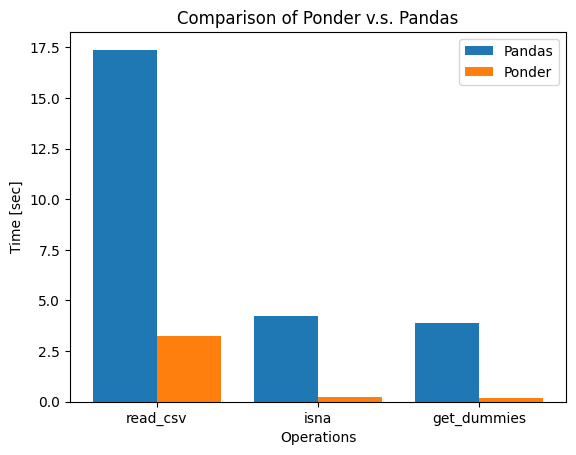

In [30]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['read_csv','isna','get_dummies']
t_pandas = [pandas_op1_duration,pandas_op2_duration,pandas_op3_duration]
t_ponder = [ponder_op1_duration,ponder_op2_duration,ponder_op3_duration]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, t_pandas, 0.4, label = 'Pandas')
plt.bar(X_axis + 0.2, t_ponder, 0.4, label = 'Ponder')
  
plt.xticks(X_axis, X)
plt.xlabel("Operations")
plt.ylabel("Time [sec]")
plt.title("Comparison of Ponder v.s. Pandas")
plt.legend()
plt.show()

In [31]:
df = pandas.DataFrame(zip(*[t_ponder, t_pandas]),columns=["Ponder","Pandas"])
df.index=X
df["Speedup"]=(df["Pandas"]/df["Ponder"]).astype(int).astype(str)+"X"
df

,Ponder,Pandas,Speedup
read_csv,3.227128,17.392146,5X
isna,0.225141,4.222649,18X
get_dummies,0.192491,3.880005,20X


By running Ponder on DuckDB, you get significant performance speedup right out of the box without any additional infrastructure setup or any manual optimization. Ponder leverages the parallel query processing capability in DuckDB to speed up your pandas queries, leading to runtimes that are much faster than vanilla pandas. All you need to do is keep writing pandas!

We did this quick experiment on a moderately sized dataset (~1.6GB). You can see that in a separate benchmark we've ran the benefits of Ponder increases as we scale up to large datasets. 

<img src="https://ponder.io/wp-content/uploads/2023/05/newplot-2-1.png" width="75%"></img>

Ponder on DuckDB is free for anyone to try out. Sign up [here](https://app.ponder.io/signup) to try it today!